## Define `image_to_base64` function

In [1]:
import base64
from typing import Union

def image_to_base64(file_path: str) -> Union[str, None]:
    """
    Reads an image file from the given file path and returns its content encoded in base64.

    Args:
        file_path (str): The path to the image file (e.g., png, jpg).

    Returns:
        Union[str, None]: The base64 encoded content of the image file, or None if the file could not be read.
    """
    try:
        # Open the image file in binary read mode
        with open(file_path, "rb") as image_file:
            # Read the entire content of the file
            image_content = image_file.read()

            # Encode the content to base64
            base64_encoded_image = base64.b64encode(image_content)

            # Decode the base64 bytes to a string
            base64_string = base64_encoded_image.decode('utf-8')

            return base64_string
    except Exception as e:
        # Handle exceptions (e.g., file not found, permission issues)
        print(f"An error occurred: {e}")
        return None

You'll need to upload a document (`.png` or `.jpg` file format) that has text inside.

## Run `image_to_base64` function

In [2]:
# Example usage
image_base64 = image_to_base64("/content/false-insurance-policy.jpeg")
print(image_base64)

/9j/4AAQSkZJRgABAQAAAQABAAD/4gxYSUNDX1BST0ZJTEUAAQEAAAxITGlubwIQAABtbnRyUkdCIFhZWiAHzgACAAkABgAxAABhY3NwTVNGVAAAAABJRUMgc1JHQgAAAAAAAAAAAAAAAAAA9tYAAQAAAADTLUhQICAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABFjcHJ0AAABUAAAADNkZXNjAAABhAAAAGx3dHB0AAAB8AAAABRia3B0AAACBAAAABRyWFlaAAACGAAAABRnWFlaAAACLAAAABRiWFlaAAACQAAAABRkbW5kAAACVAAAAHBkbWRkAAACxAAAAIh2dWVkAAADTAAAAIZ2aWV3AAAD1AAAACRsdW1pAAAD+AAAABRtZWFzAAAEDAAAACR0ZWNoAAAEMAAAAAxyVFJDAAAEPAAACAxnVFJDAAAEPAAACAxiVFJDAAAEPAAACAx0ZXh0AAAAAENvcHlyaWdodCAoYykgMTk5OCBIZXdsZXR0LVBhY2thcmQgQ29tcGFueQAAZGVzYwAAAAAAAAASc1JHQiBJRUM2MTk2Ni0yLjEAAAAAAAAAAAAAABJzUkdCIElFQzYxOTY2LTIuMQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAWFlaIAAAAAAAAPNRAAEAAAABFsxYWVogAAAAAAAAAAAAAAAAAAAAAFhZWiAAAAAAAABvogAAOPUAAAOQWFlaIAAAAAAAAGKZAAC3hQAAGNpYWVogAAAAAAAAJKAAAA+EAAC2z2Rlc2MAAAAAAAAAFklFQyBodHRwOi8vd3d3LmllYy5jaAAAAAAAAAAAAAAAFklFQyBodHRwOi8vd3d3LmllYy5jaAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABkZXNj

## Define `post_request_and_parse_response` function

In [3]:
import requests
import json
from typing import Dict, Any

def post_request_and_parse_response(
    url: str, payload: Dict[str, Any]
) -> Dict[str, Any]:
    """
    Sends a POST request to the specified URL with the given payload,
    then parses the byte response to a dictionary.
    Args:
    url (str): The URL to which the POST request is sent.
    payload (Dict[str, Any]): The payload to send in the POST request.
    Returns:
    Dict[str, Any]: The parsed dictionary from the response.
    """
    # Set headers for the POST request
    headers = {"Content-Type": "application/json"}

    # Send the POST request and get the response
    response = requests.post(url, json=payload, headers=headers)

    # Extract the byte data from the response
    byte_data = response.content

    # Decode the byte data to a string
    decoded_string = byte_data.decode("utf-8")

    # Convert the JSON string to a dictionary
    dict_data = json.loads(decoded_string)

    return dict_data

## Run `post_request_and_parse_response` function

In [4]:
url = "https://2tsig211e0.execute-api.us-east-1.amazonaws.com/my_textract"
payload = {"image": image_base64}
result_dict = post_request_and_parse_response(url, payload)

## Define `draw_bounding_boxes_for_textract` function

In [5]:
import json
from typing import Dict, Any
from PIL import Image, ImageDraw

def draw_bounding_boxes_for_textract(
    image: Image.Image, json_data: Dict[str, Any]
) -> Image.Image:
    """
    Draws bounding boxes on an image based on the provided JSON data from Textract.

    Args:
        image (Image.Image): The image on which to draw bounding boxes.
        json_data (Dict[str, Any]): The JSON data containing the bounding box information from Textract.

    Returns:
        Image.Image: A PIL Image object with bounding boxes drawn.
    """
    # Create a drawing object
    draw = ImageDraw.Draw(image)

    # Parse the JSON data
    try:
        data = json_data
        blocks = json.loads(data["body"]) if "body" in data else None
    except json.JSONDecodeError:
        print("Invalid JSON data.")
        return image

    if blocks is None:
        print("No bounding box data found.")
        return image

    # Iterate through the elements to find bounding boxes and draw them
    for item in blocks:
        if "BlockType" in item and item["BlockType"] in ["LINE", "WORD"]:
            bbox = item["Geometry"]["BoundingBox"]
            # Extract coordinates and dimensions
            left, top, width, height = (
                bbox["Left"],
                bbox["Top"],
                bbox["Width"],
                bbox["Height"],
            )
            # Calculate bounding box coordinates in image space
            left_top = (left * image.width, top * image.height)
            right_bottom = ((left + width) * image.width, (top + height) * image.height)
            # Draw rectangle
            draw.rectangle([left_top, right_bottom], outline="red", width=2)

    return image

## Run `draw_bounding_boxes_for_textract` function

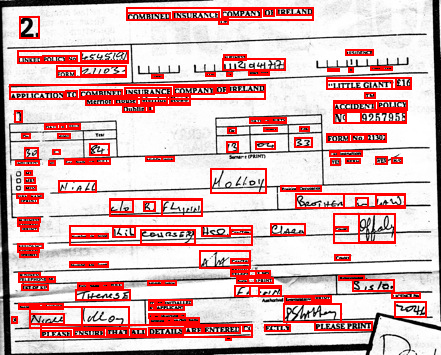

In [6]:
# Example usage
from PIL import Image
image = Image.open("/content/false-insurance-policy.jpeg")
json_data = result_dict  # Your Textract JSON data
image_with_boxes = draw_bounding_boxes_for_textract(image, json_data)
image_with_boxes  # To display the image in the Jupyter Notebook

## Define `extract_text_from_textract_output` function

In [17]:
import json
from typing import Dict, Any, List

def extract_text_from_textract_output(json_data: Dict[str, Any]) -> List[str]:
    """
    Extracts text from the JSON output of Amazon Textract.

    Args:
        json_data (Dict[str, Any]): The JSON data containing the text blocks from Textract.

    Returns:
        List[str]: A list of extracted text strings from the Textract output.
    """

    # Parse the JSON data
    try:
        blocks = json.loads(json_data["body"]) if "body" in json_data else None
    except json.JSONDecodeError:
        print("Invalid JSON data.")
        return []

    if blocks is None:
        print("No text block data found.")
        return []

    # Iterate through the elements to extract text from LINE and WORD blocks
    texts = []
    for item in blocks:
        if "BlockType" in item and item["BlockType"] in ["LINE", "WORD"]:
            current_text = item["Text"]
            # Append text to the list
            texts.append(current_text)

    return texts

## Run `extract_text_from_textract_output` function

In [19]:
extracted_texts = extract_text_from_textract_output(json_data)
extracted_texts = ' '.join(extracted_texts)
extracted_texts

'COMBINED INSURANCE COMPANY OF IRELAND 2. TM LINKED POLICY No. 4545191 BUSINESS RESIDENCE FORM 21103. 111214477 - - - . - - - NAME - APPLICATION TO COMBINED INSURANCE COMPANY OF IRELAND "LITTLE GIANT" £16 Merrion House, Merrion Road, TM Dublin 4. ACCIDENT POLICY ) DATE OF BIRTH No 9257958 DATE OF ISSUE Day - To Day Month 30 is 84. 13 or 33. FORM No. 21302 Call - POLICED - Fee Name - PULL Made - VS PERM 23 we we was MISS NiALL Molloy Passion Comparent FIRM NAME (PRINT) c/o. R. Flaporal BROTHER in wow. MISINESS ADDRESS (PRINT) Number - - KiL COURSER) Hse. Certified Clasa County offaly RESIDENCE ADDRESS PRINTS Number - - A be com Certa Can sauda RESIDENT TELEPH IN TELEPHONE NO form (PRINT) - ST OF AIR First - - FULL Middle - THeness F. NN Sisla, TO - INITIALLED - PRINTS LICENSE - of Applicant BY APPLICANT x Niall (dloy . - - - - of - - PShittan 2046 PLEASE ENSURE THAT ALL DETAILS ARE ENTERED a ECTLY PLEASE PRINT . COMBINED INSURANCE COMPANY OF IRELAND 2. TM LINKED POLICY No. 4545191 BUSIN

In [7]:
! pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.6/320.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.2 MB/s eta 0:00:00


In [9]:
from google.colab import userdata
key = userdata.get('OPENAI_API_KEY')

In [10]:
from openai import OpenAI
client = OpenAI(api_key=key)

In [20]:
def call_chatgpt(question: str, policy: str, content: str, safeguard: str) -> str:
    """
    Calls the GPT model using the provided client to generate a response to a given question.

    The function takes a question as input and interacts with an OpenAI GPT model through the client's chat
    completion API. If there is any exception during the API call, it catches the exception and provides a
    default error response.

    Parameters:
    question (str): The user's question that needs to be sent to the GPT model.

    Returns:
    str: The generated response from the GPT model. In case of an error, a default error message is returned.
    """
    try:
        # Generate a response using the GPT model specified, with a fixed system role message followed by the user's question.
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": f"Here is the policy I want you to follow: {policy}"},
                {"role": "system", "content": "Is there any info I can use?"},
                {"role": "user", "content": f"Please use the information from following content: {content}"},
                {"role": "system", "content": f"Anything you want me to be aware of?"},
                {"role": "user", "content": f"Please regard the following safeguard protocol: {safeguard}"},
                {"role": "system", "content": "What's the question?"},
                {"role": "user", "content": question}
            ],
        )
        # Extract the content of the message received from the GPT model.
        output = response.choices[0].message.content
    except Exception as e:
        # Print the exception and return a default error message if any exception occurs.
        print(e)
        output = "Sorry, I couldn't get an answer for that."

    return output

In [37]:
config_file = {
    "question": "What's the first name?",
    "policy": "answer the question using the content",
    "content": extracted_texts,
    "safeguard": "just provide the answer directly, don't overwrite it, if you don't know the answer, just say NA."
}

first_name = call_chatgpt(
    question=config_file["question"],
    policy=config_file["policy"],
    content=config_file["content"],
    safeguard=config_file["safeguard"]
)

config_file["question"] = "What's the last name?"

last_name = call_chatgpt(
    question=config_file["question"],
    policy=config_file["policy"],
    content=config_file["content"],
    safeguard=config_file["safeguard"]
)

config_file["question"] = "What's the insurance policy numnber?"

insurance_policy_number = call_chatgpt(
    question=config_file["question"],
    policy=config_file["policy"],
    content=config_file["content"],
    safeguard=config_file["safeguard"]
)

print("Output:")
print("-------")
print(first_name, last_name, insurance_policy_number)

Output:
-------
The first name is Niall. The last name is Molloy. The insurance policy number is 4545191.
